In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from helper.utils import *
import pandas as pd

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # hide tensorflow warning

In [3]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [4]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [5]:
words = merged_data[1]
tags = merged_data[2]

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)

In [7]:
num_words = max([len(tokenizer.word_index)]) + 1
max_len = max([len(i) for i in words])
print("Vocab size: ", num_words)
print("Max length: ", max_len)

Vocab size:  22705
Max length:  44


In [8]:
unique_tags = np.unique(tags)
num_tags = len(np.unique(tags))
# print(num_tags)
print(unique_tags)

['EN' 'ID' 'JV' 'MIX-ID-EN' 'MIX-ID-JV' 'MIX-JV-EN' 'O']


In [9]:
def x_to_padded(word_list, max_len):
    # input: list of words
    # output:
    X_seq = tokenizer.texts_to_sequences(word_list)
    X_padded = pad_sequences(sequences=X_seq, maxlen=max_len, padding='post')
    # print("Training data sample: ", X_padded[10:][:3])

    return X_padded

In [10]:
X_train = x_to_padded(train_data[1], max_len)
y_train = pd.get_dummies(train_data[2])
X_val = x_to_padded(val_data[1], max_len)
y_val = pd.get_dummies(val_data[2])
X_test = x_to_padded(test_data[1], max_len)
y_test = pd.get_dummies(test_data[2])

In [11]:
print(X_train.shape)
print(y_train.shape)

(71532, 44)
(71532, 7)


In [12]:
model = multi_cnn_lstm_model(num_words, num_tags, max_len)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 44, 50)       1135250     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 43, 64)       6464        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 42, 64)       9664        ['embedding[0][0]']              
                                                                                              

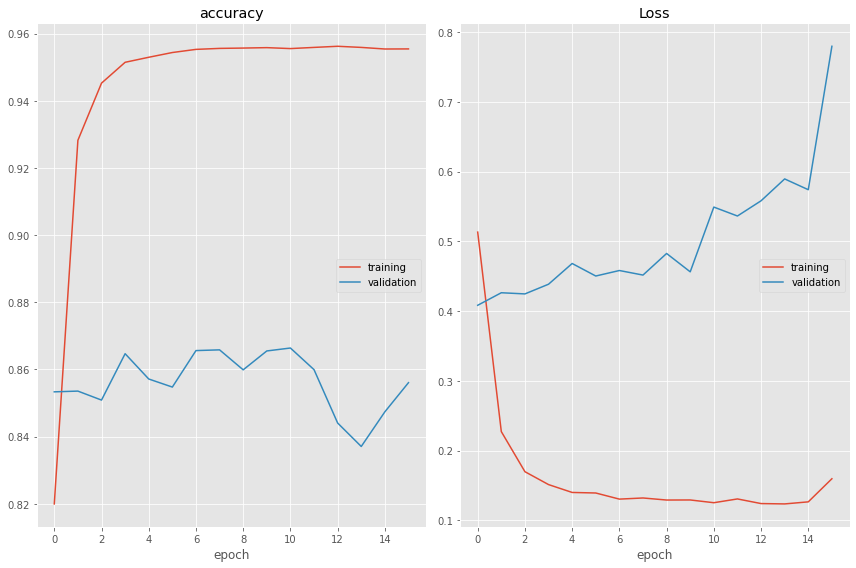

accuracy
	training         	 (min:    0.820, max:    0.956, cur:    0.955)
	validation       	 (min:    0.837, max:    0.866, cur:    0.856)
Loss
	training         	 (min:    0.124, max:    0.513, cur:    0.160)
	validation       	 (min:    0.408, max:    0.780, cur:    0.780)

Epoch 16: val_loss did not improve from 0.40832
1374/1374 [==============================] - 9s 7ms/step - loss: 0.7637 - accuracy: 0.8553
[0.7636561393737793, 0.8552960753440857]


In [13]:
root_path = 'model/'
model_name = 'm_cnn_lstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [14]:
# model.save('model/m_cnn_lstm_model.h5')

In [15]:
#Get encoded label
y_test['encoded_label'] = y_test.values.argmax(1)
print(y_test['encoded_label'])
y_test_value = y_test['encoded_label']

0        1
1        1
2        0
3        1
4        6
        ..
43933    6
43934    1
43935    6
43936    6
43937    6
Name: encoded_label, Length: 43938, dtype: int64


In [16]:
y_test_result = history.model.predict(X_test)
y_pred = np.argmax(y_test_result, axis=-1)

In [17]:
idx_tag = tag2idx(unique_tags, 0)
idx_tag

{'EN': 0,
 'ID': 1,
 'JV': 2,
 'MIX-ID-EN': 3,
 'MIX-ID-JV': 4,
 'MIX-JV-EN': 5,
 'O': 6}

In [18]:
y_test_actual = []
for value in y_test_value:
    label = [k for k,v in idx_tag.items() if v == value]
    y_test_actual.append(label)

y_pred_ = []
for value in y_pred:
    label = [k for k,v in idx_tag.items() if v == value]
    y_pred_.append(label)

              precision    recall  f1-score   support

          ID     0.9346    0.8782    0.9055     22309
          JV     0.9155    0.6105    0.7325      4916
          EN     0.9473    0.7839    0.8579      5020
   MIX-ID-EN     0.9405    0.7801    0.8528       973
   MIX-ID-JV     0.9833    0.8393    0.9056       280
   MIX-JV-EN     0.7158    0.7545    0.7346       277
           O     0.6933    0.9692    0.8084     10163

    accuracy                         0.8553     43938
   macro avg     0.8758    0.8022    0.8282     43938
weighted avg     0.8772    0.8553    0.8560     43938



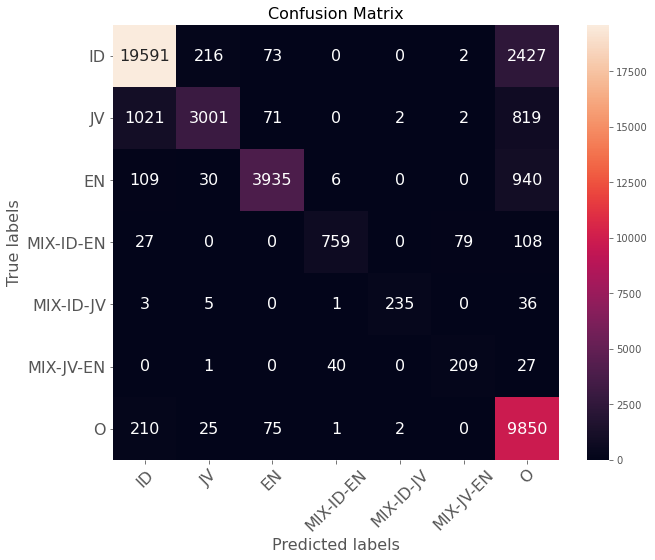

In [19]:
performance_report(y_test_actual, y_pred_)

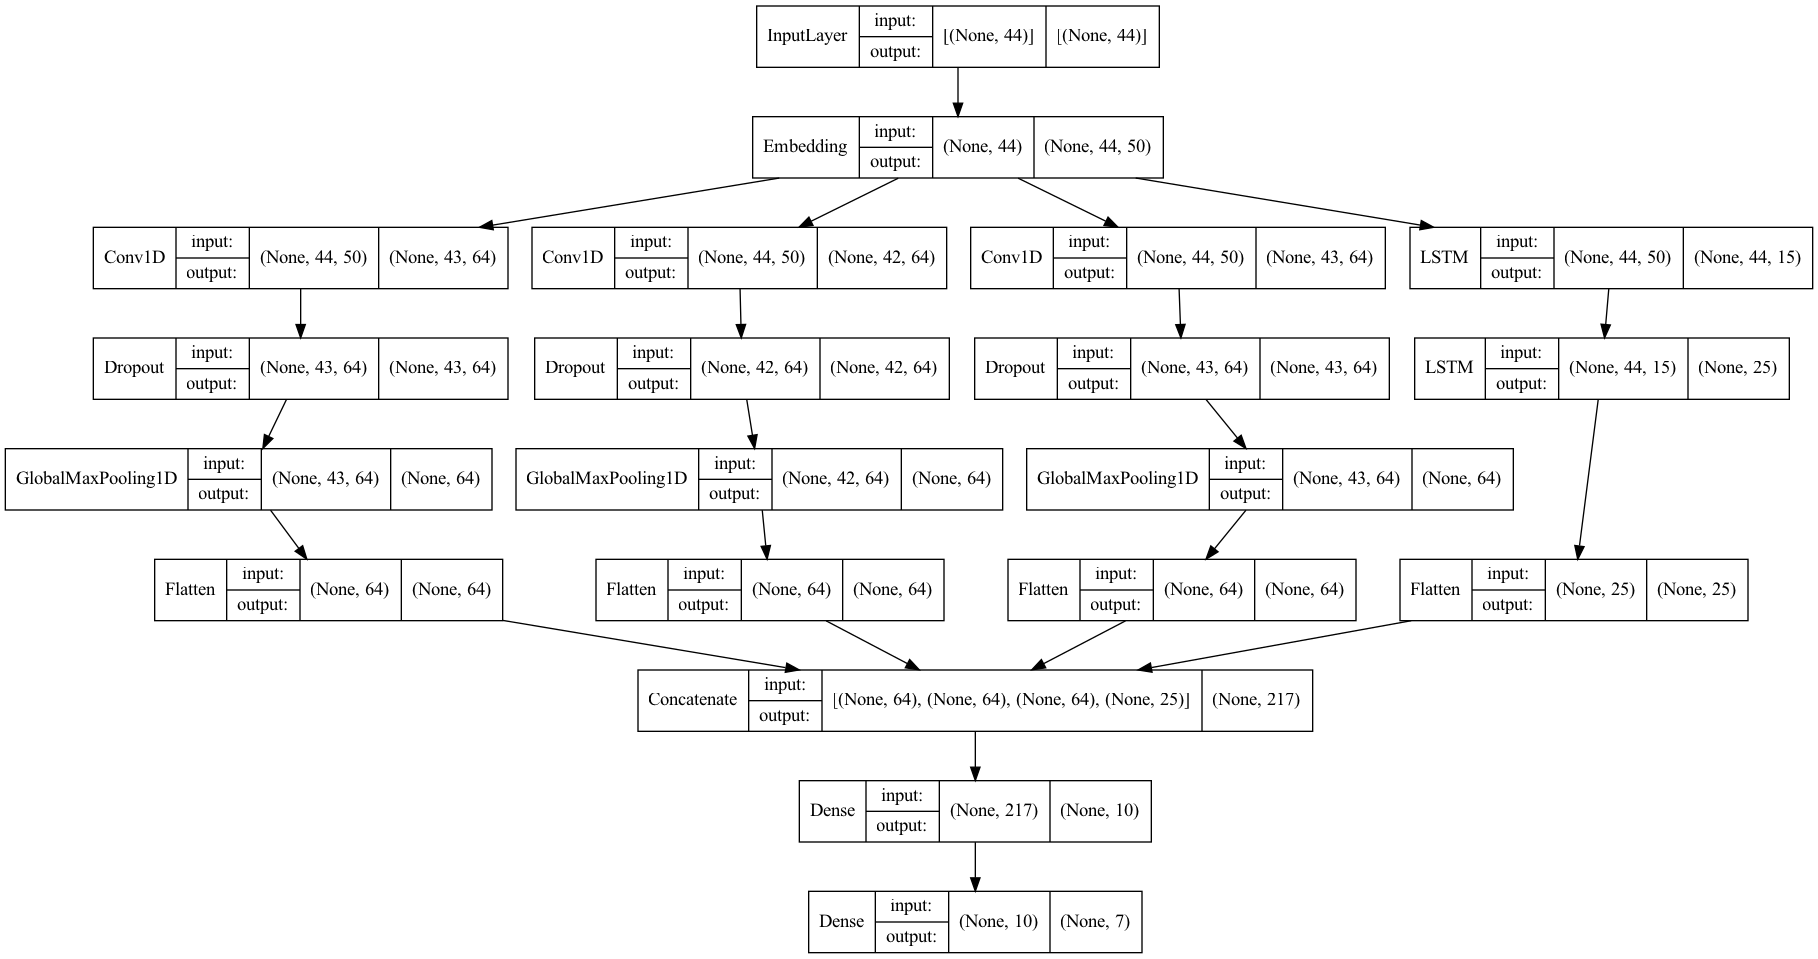

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_mcnn_lstm.png', show_shapes=True, show_layer_names=False)